In [279]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
pd.set_option('use_inf_as_na', True)
from collections import Counter

In [280]:
raw_data = pd.read_pickle(r'C:\Users\niels\OneDrive\Machine Learning 2022\Lecture 2\dataset.pkl')

In [281]:
raw_data = raw_data.drop([x  for x in raw_data.columns if 'fqtr' in x],axis=1)

In [282]:
data = raw_data[raw_data['market_cap'] > 1000.0]

In [283]:
data = data.copy()
data.fillna(0.0,inplace=True)

In [284]:
def f(x):
    if x > 0.01:
        return 1
    elif x < -0.025:
        return -1
    else:
    
        return 0

In [285]:
data['rel_performance'] = data['pred_rel_return'].apply(f)

In [368]:
data.reset_index(inplace=True,)
data.set_index('date',inplace=True)

data.sort_index()
data.head()

df_train = data.loc['2001-01-01':'2004-01-01']

df_valid = data.loc['2004-04-01':'2004-07-01']
df_test = data.loc['2004-07-01':'2004-10-01']

train = df_train.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1)


valid = df_valid.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1)
test = df_test.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1)

train_stock_returns = df_train['next_period_return']
valid_stock_returns = df_valid['next_period_return']
test_stock_returns = df_test['next_period_return']

y_train = df_train['rel_performance']
y_valid = df_valid['rel_performance']
y_test = df_test['rel_performance']

y_train = y_train.values
y_valid = y_valid.values
y_test = y_test.values

In [369]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler

In [370]:
scaler = StandardScaler()

In [371]:
float_vars = [x for x in train.columns if data[x].dtype == 'float64']

In [372]:
len(float_vars)

179

In [373]:
train_norm = train.copy()
valid_norm = valid.copy()
test_norm = test.copy()

In [374]:
train_norm[float_vars] = scaler.fit_transform(train[float_vars])
valid_norm[float_vars] = scaler.transform(valid[float_vars])
test_norm[float_vars] = scaler.transform(test[float_vars])

In [375]:
t_clf = DecisionTreeClassifier(max_depth=6,min_samples_leaf=200)

In [376]:
bg_clf = BaggingClassifier(t_clf,n_estimators=40,random_state=123,n_jobs=-1)

In [377]:
bg_clf.fit(train_norm,y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=6,
                                                        min_samples_leaf=200),
                  n_estimators=40, n_jobs=-1, random_state=123)

In [378]:
def bagging_feat_importance(m, df):
    feature_importances = []
    for est in m.estimators_:
        fi = est.feature_importances_
        feature_importances.append(fi)
    feature_importances = np.array(feature_importances)
        
    return pd.DataFrame({'cols':train.columns, 'feat_imp':np.mean(feature_importances,axis=0)}
                       ).sort_values('feat_imp', ascending=False)


def plot_fi(fi): return fi.plot('cols', 'feat_imp', 'barh', figsize=(12,7), legend=False)

In [379]:
fi = bagging_feat_importance(bg_clf,train)

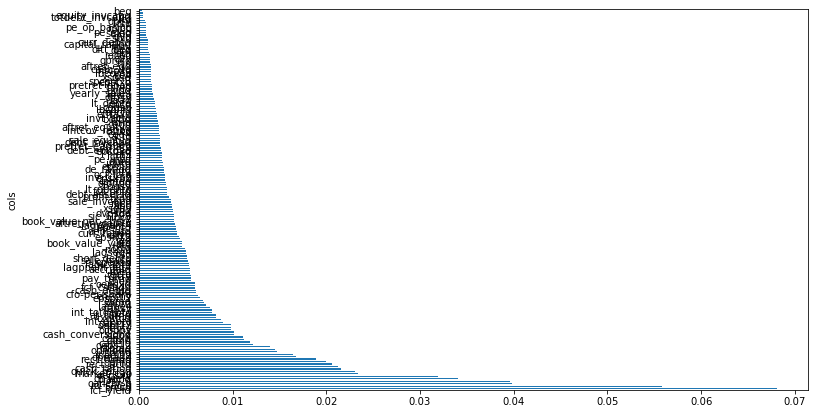

In [380]:
features = fi[(fi['feat_imp'] > 0.0)]
plot_fi(features);

In [381]:
len(features)

155

In [382]:
bg_clf.score(train,y_train)

0.5791708983473364

In [383]:
bg_clf.score(valid,y_valid)

0.5445887445887446

In [387]:
pred_valid = bg_clf.predict(valid_norm)

In [388]:
Counter(pred_valid)

Counter({1: 1127, -1: 28})

In [389]:
Counter(y_valid)

Counter({1: 628, -1: 402, 0: 125})

In [390]:
profit = (pred_valid*valid_stock_returns).sum()
profit

-12.83161799999998

In [391]:
import optuna
from optuna.trial import Trial

In [392]:
def objective(trial:Trial,train=None,labels=None,val=None,val_labels=None,val_rets=None):

    t_min_samples_leaf = trial.suggest_int('min_samples_leaf',100,1200,step=100)
    t_max_depth = trial.suggest_int('max_depth',5,25,step=5)
    t_n_estimators = trial.suggest_int('n_estimators',5,50,step=5)

    
    t_clf = DecisionTreeClassifier(min_samples_leaf = t_min_samples_leaf,max_depth=t_max_depth,random_state=123)
    bg_clf = BaggingClassifier(t_clf,n_estimators=t_n_estimators,random_state=123,n_jobs=1)
    bg_clf.fit(train,labels)

    preds = bg_clf.predict(val)
    profit = (preds * val_rets).sum()

#     score = bg_clf.score(val,val_labels)

    return profit

In [393]:
study = optuna.create_study(direction="maximize")

[I 2023-01-15 10:37:51,525] A new study created in memory with name: no-name-cede30ae-768b-4dea-8c03-5bc17aab3131


In [303]:
from functools import partial

In [394]:
%%time
study.optimize(partial(objective,train=train_norm,labels=y_train,val=valid_norm,val_labels=y_valid,val_rets=valid_stock_returns.values), n_trials=200,n_jobs=-1)

[I 2023-01-15 10:38:35,905] Trial 5 finished with value: -26.068305999999993 and parameters: {'min_samples_leaf': 1000, 'max_depth': 20, 'n_estimators': 10}. Best is trial 5 with value: -26.068305999999993.
[I 2023-01-15 10:38:37,102] Trial 3 finished with value: -8.359655999999983 and parameters: {'min_samples_leaf': 100, 'max_depth': 15, 'n_estimators': 5}. Best is trial 3 with value: -8.359655999999983.
[I 2023-01-15 10:38:38,663] Trial 6 finished with value: -8.225577999999976 and parameters: {'min_samples_leaf': 400, 'max_depth': 10, 'n_estimators': 10}. Best is trial 6 with value: -8.225577999999976.
[I 2023-01-15 10:38:40,883] Trial 1 finished with value: -26.068305999999993 and parameters: {'min_samples_leaf': 1000, 'max_depth': 10, 'n_estimators': 20}. Best is trial 6 with value: -8.225577999999976.
[I 2023-01-15 10:38:41,053] Trial 4 finished with value: -10.70270999999998 and parameters: {'min_samples_leaf': 500, 'max_depth': 5, 'n_estimators': 15}. Best is trial 6 with valu

[I 2023-01-15 10:40:01,625] Trial 42 finished with value: -10.142967999999971 and parameters: {'min_samples_leaf': 200, 'max_depth': 15, 'n_estimators': 5}. Best is trial 15 with value: -7.354863999999973.
[I 2023-01-15 10:40:04,419] Trial 27 finished with value: -11.256269999999981 and parameters: {'min_samples_leaf': 400, 'max_depth': 25, 'n_estimators': 50}. Best is trial 15 with value: -7.354863999999973.
[I 2023-01-15 10:40:06,236] Trial 43 finished with value: -10.142967999999971 and parameters: {'min_samples_leaf': 200, 'max_depth': 15, 'n_estimators': 5}. Best is trial 15 with value: -7.354863999999973.
[I 2023-01-15 10:40:08,392] Trial 38 finished with value: -13.193449999999975 and parameters: {'min_samples_leaf': 200, 'max_depth': 15, 'n_estimators': 15}. Best is trial 15 with value: -7.354863999999973.
[I 2023-01-15 10:40:09,253] Trial 40 finished with value: -13.193449999999975 and parameters: {'min_samples_leaf': 200, 'max_depth': 15, 'n_estimators': 15}. Best is trial 15

[I 2023-01-15 10:41:33,262] Trial 69 finished with value: -12.936817999999976 and parameters: {'min_samples_leaf': 300, 'max_depth': 15, 'n_estimators': 35}. Best is trial 15 with value: -7.354863999999973.
[I 2023-01-15 10:41:33,726] Trial 72 finished with value: -12.468061999999977 and parameters: {'min_samples_leaf': 300, 'max_depth': 15, 'n_estimators': 25}. Best is trial 15 with value: -7.354863999999973.
[I 2023-01-15 10:41:33,946] Trial 80 finished with value: -7.354863999999973 and parameters: {'min_samples_leaf': 300, 'max_depth': 20, 'n_estimators': 5}. Best is trial 15 with value: -7.354863999999973.
[I 2023-01-15 10:41:34,231] Trial 81 finished with value: -7.354863999999973 and parameters: {'min_samples_leaf': 300, 'max_depth': 20, 'n_estimators': 5}. Best is trial 15 with value: -7.354863999999973.
[I 2023-01-15 10:41:37,156] Trial 82 finished with value: -7.354863999999973 and parameters: {'min_samples_leaf': 300, 'max_depth': 20, 'n_estimators': 5}. Best is trial 15 wit

[I 2023-01-15 10:42:07,293] Trial 114 finished with value: -2.9952099999999753 and parameters: {'min_samples_leaf': 500, 'max_depth': 25, 'n_estimators': 5}. Best is trial 106 with value: -2.9952099999999753.
[I 2023-01-15 10:42:07,570] Trial 115 finished with value: -2.9952099999999753 and parameters: {'min_samples_leaf': 500, 'max_depth': 25, 'n_estimators': 5}. Best is trial 106 with value: -2.9952099999999753.
[I 2023-01-15 10:42:09,050] Trial 116 finished with value: -2.9952099999999753 and parameters: {'min_samples_leaf': 500, 'max_depth': 25, 'n_estimators': 5}. Best is trial 106 with value: -2.9952099999999753.
[I 2023-01-15 10:42:10,268] Trial 117 finished with value: -2.9952099999999753 and parameters: {'min_samples_leaf': 500, 'max_depth': 25, 'n_estimators': 5}. Best is trial 106 with value: -2.9952099999999753.
[I 2023-01-15 10:42:10,757] Trial 118 finished with value: -2.9952099999999753 and parameters: {'min_samples_leaf': 500, 'max_depth': 25, 'n_estimators': 5}. Best i

[I 2023-01-15 10:42:48,770] Trial 153 finished with value: -2.9952099999999753 and parameters: {'min_samples_leaf': 500, 'max_depth': 25, 'n_estimators': 5}. Best is trial 106 with value: -2.9952099999999753.
[I 2023-01-15 10:42:48,981] Trial 154 finished with value: -2.9952099999999753 and parameters: {'min_samples_leaf': 500, 'max_depth': 25, 'n_estimators': 5}. Best is trial 106 with value: -2.9952099999999753.
[I 2023-01-15 10:42:49,760] Trial 155 finished with value: -2.9952099999999753 and parameters: {'min_samples_leaf': 500, 'max_depth': 25, 'n_estimators': 5}. Best is trial 106 with value: -2.9952099999999753.
[I 2023-01-15 10:42:50,202] Trial 156 finished with value: -2.9952099999999753 and parameters: {'min_samples_leaf': 500, 'max_depth': 25, 'n_estimators': 5}. Best is trial 106 with value: -2.9952099999999753.
[I 2023-01-15 10:42:50,906] Trial 136 finished with value: -26.068305999999993 and parameters: {'min_samples_leaf': 600, 'max_depth': 25, 'n_estimators': 30}. Best 

[I 2023-01-15 10:43:14,487] Trial 188 finished with value: -2.9952099999999753 and parameters: {'min_samples_leaf': 500, 'max_depth': 25, 'n_estimators': 5}. Best is trial 106 with value: -2.9952099999999753.
[I 2023-01-15 10:43:16,690] Trial 189 finished with value: -2.9952099999999753 and parameters: {'min_samples_leaf': 500, 'max_depth': 25, 'n_estimators': 5}. Best is trial 106 with value: -2.9952099999999753.
[I 2023-01-15 10:43:16,927] Trial 190 finished with value: -2.9952099999999753 and parameters: {'min_samples_leaf': 500, 'max_depth': 25, 'n_estimators': 5}. Best is trial 106 with value: -2.9952099999999753.
[I 2023-01-15 10:43:18,350] Trial 191 finished with value: -2.9952099999999753 and parameters: {'min_samples_leaf': 500, 'max_depth': 25, 'n_estimators': 5}. Best is trial 106 with value: -2.9952099999999753.
[I 2023-01-15 10:43:19,112] Trial 192 finished with value: -2.9952099999999753 and parameters: {'min_samples_leaf': 500, 'max_depth': 25, 'n_estimators': 5}. Best i

CPU times: total: 31min 19s
Wall time: 4min 50s


In [396]:
study.best_params

{'min_samples_leaf': 500, 'max_depth': 25, 'n_estimators': 5}

In [397]:
t_cfl = DecisionTreeClassifier(**{'min_samples_leaf': 500, 'max_depth': 5},random_state=123)
bg_clf = BaggingClassifier(t_clf,n_estimators=5,random_state=123)

In [399]:
bg_clf.fit(train_norm,y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=6,
                                                        min_samples_leaf=200),
                  n_estimators=5, random_state=123)

In [400]:
pred_valid = bg_clf.predict(valid_norm)

In [401]:
bg_clf.score(train_norm,y_train)

0.5923737420367464

In [402]:
bg_clf.score(valid_norm,y_valid)

0.5645021645021645

In [403]:
confusion_matrix(pred_valid,y_valid)

array([[ 33,   2,   9],
       [  0,   0,   0],
       [369, 123, 619]], dtype=int64)

In [404]:
(pred_valid * df_valid['next_period_return'].values).sum()

-10.95675999999997

In [406]:
fi = bagging_feat_importance(bg_clf,train_norm)

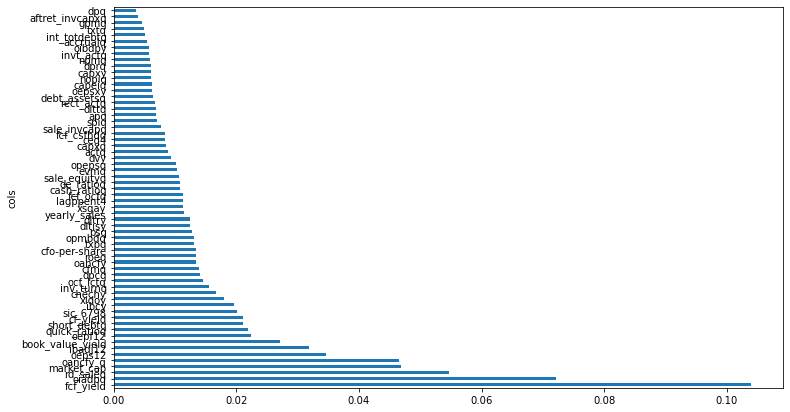

In [407]:
features = fi[(fi['feat_imp'] > 0.0)]
plot_fi(features);

In [408]:
features

,cols,feat_imp
156,fcf_yield,0.103983
40,oiadpq,0.072066
176,rd_saleq,0.054744
92,market_cap,0.046889
102,oancfy_q,0.046559
...,...,...
142,int_totdebtq,0.005082
59,txtq,0.004987
112,gpmq,0.004585
132,aftret_invcapxq,0.003935


In [409]:
cols = features['cols'].values

In [411]:
cols

array(['fcf_yield', 'oiadpq', 'rd_saleq', 'market_cap', 'oancfy_q',
       'oeps12', 'ibadj12', 'book_value_yield', 'oepf12', 'quick_ratioq',
       'short_debtq', 'cf_yield', 'sic_6798', 'ibcy', 'xidoy', 'chechy',
       'inv_turnq', 'ocf_lctq', 'dpcq', 'cfmq', 'oancfy', 'roeq',
       'cfo-per-share', 'txpq', 'opmbdq', 'psq', 'dltisy', 'dltry',
       'yearly_sales', 'xsgay', 'lagppent4', 'fcf_ocfq', 'cash_ratioq',
       'de_ratioq', 'sale_equityq', 'evmq', 'opepsq', 'dvy', 'actq',
       'capxq', 'ceq4', 'fcf_csfhdq', 'sale_invcapq', 'spiq', 'apq',
       'dlttq', 'rect_actq', 'debt_assetsq', 'oepsxy', 'capeiq', 'nopiq',
       'capxy', 'dprq', 'npmq', 'invt_actq', 'oibdpy', 'accrualq',
       'int_totdebtq', 'txtq', 'gpmq', 'aftret_invcapxq', 'dpq'],
      dtype=object)

In [412]:
float_vars = [x for x in train[cols].columns if data[x].dtype == 'float64']

In [416]:
len(float_vars)

61

In [414]:
train_red_norm = train.copy()
valid_red_norm = valid.copy()
test_red_norm = test.copy()

In [417]:
(train[cols])[float_vars]

,fcf_yield,oiadpq,rd_saleq,market_cap,oancfy_q,oeps12,ibadj12,book_value_yield,oepf12,quick_ratioq,...,dprq,npmq,invt_actq,oibdpy,accrualq,int_totdebtq,txtq,gpmq,aftret_invcapxq,dpq
0,-0.018069,65.238,0.000000,3328.613563,-28.850,1.0300,176.894,0.258732,1.0300,0.317598,...,0.257194,0.048261,0.830815,80.152,-22.188,0.000000,23.777,0.298141,0.294123,14.914
1,0.066848,706.759,0.000000,17239.971000,0.000,2.0900,0.000,0.875620,2.0900,0.000000,...,0.000000,0.000000,0.000000,0.000,0.000,0.000000,500.314,0.000000,0.000000,0.000
2,0.000000,119.606,0.000000,5006.277813,0.000,1.1000,182.935,0.299951,1.1000,0.000000,...,0.000000,0.000000,0.000000,556.662,0.000,0.000000,10.067,0.000000,0.000000,35.677
3,0.032548,6880.430,0.000000,55073.831760,18080.311,0.0000,0.000,0.000000,0.0000,0.000000,...,0.000000,0.000000,0.000000,23218.970,0.000,0.000000,317.323,0.000000,0.000000,243.786
4,0.053088,401.000,0.000000,13470.818438,454.000,2.0400,0.000,0.366496,2.0100,1.815374,...,0.000000,0.033685,0.061251,993.000,1188.000,0.085862,117.000,0.161122,0.000000,105.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10826,-0.018673,450.630,0.000000,10989.340000,918.053,4.2500,0.000,0.782038,4.2500,0.000000,...,0.000000,0.000000,0.000000,695.292,0.000,0.000000,88.236,0.000000,0.000000,244.662
10827,0.096960,134.596,0.000000,3457.556200,19.060,1.9700,248.461,0.000000,1.9600,0.417276,...,0.308515,0.012294,0.615851,664.843,408.879,0.079209,40.931,0.150165,0.396773,68.564
10828,0.038298,18.401,0.000000,1022.517050,14.156,1.1033,41.485,0.000000,1.0767,4.015399,...,0.036350,0.106175,0.281997,58.473,20.592,0.000000,7.161,0.426688,0.000000,3.045
10829,-0.038154,0.600,0.156283,7924.391000,255.200,-1.4800,-961.900,0.660817,-1.4800,1.832117,...,-0.005926,-0.217111,0.191593,312.900,1395.900,0.033948,15.500,0.335997,-0.146210,312.300


In [420]:
train_red_norm[float_vars] = scaler.fit_transform((train[cols])[float_vars])
valid_red_norm[float_vars] = scaler.transform((valid[cols])[float_vars])
test_red_norm[float_vars] = scaler.transform((test[cols])[float_vars])

In [421]:
bg_clf.fit(train_red_norm,y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=6,
                                                        min_samples_leaf=200),
                  n_estimators=5, random_state=123)

In [422]:
valid_1_norm = valid_red_norm.copy()

valid_1_norm['rets'] = df_valid['next_period_return'].values

In [423]:
pred = bg_clf.predict(valid_red_norm)

In [424]:
(pred*valid_1[valid_1_norm.columns[-1]].values).sum()

-10.95675999999997

In [425]:
import shap

In [426]:
def model(features):
    tree_features = features[features.columns[:-1].values]

    pred = bg_clf.predict(tree_features)

    ret = pred * features[features.columns[-1]]

    return ret

In [430]:
explainer = shap.explainers.Permutation(model,valid_1_norm,)

In [431]:
shap_values = explainer(valid_1_norm,max_evals=2000,)

Permutation explainer: 1156it [2:09:21,  6.73s/it]                                                                     


In [329]:
shap_values.values.shape

(1155, 63)

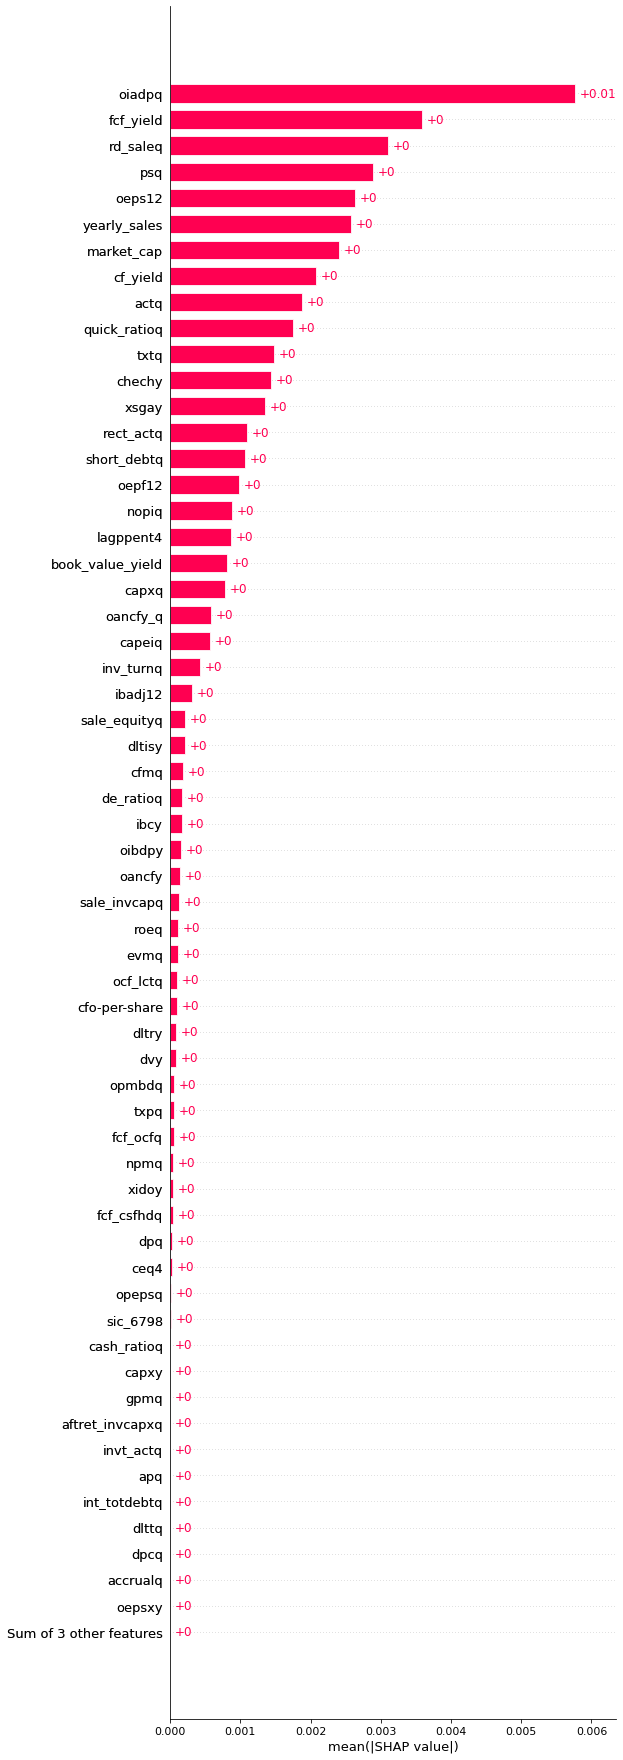

In [330]:
shap.plots.bar(shap_values[:,:-1],max_display=60,)

In [354]:
shap_cols = cols[np.abs(shap_values[:,:-1].values).mean(axis=0)>0.000]

In [355]:
shap_cols

array(['fcf_yield', 'oiadpq', 'rd_saleq', 'market_cap', 'oancfy_q',
       'oeps12', 'ibadj12', 'book_value_yield', 'oepf12', 'quick_ratioq',
       'short_debtq', 'cf_yield', 'sic_6798', 'ibcy', 'xidoy', 'chechy',
       'inv_turnq', 'ocf_lctq', 'dpcq', 'cfmq', 'oancfy', 'roeq',
       'cfo-per-share', 'txpq', 'opmbdq', 'psq', 'dltisy', 'dltry',
       'yearly_sales', 'xsgay', 'lagppent4', 'fcf_ocfq', 'cash_ratioq',
       'de_ratioq', 'sale_equityq', 'evmq', 'opepsq', 'dvy', 'actq',
       'capxq', 'ceq4', 'fcf_csfhdq', 'sale_invcapq', 'apq', 'dlttq',
       'rect_actq', 'capeiq', 'nopiq', 'capxy', 'npmq', 'invt_actq',
       'oibdpy', 'accrualq', 'int_totdebtq', 'txtq', 'gpmq',
       'aftret_invcapxq', 'dpq'], dtype=object)

In [356]:
len(shap_cols)

58

In [357]:
start_dates = [pd.to_datetime('2001-01-01') + pd.DateOffset(months = 3 * i) for i in range(57)]
end_dates = [d + pd.DateOffset(months = 36) for d in start_dates]

training_frames = [data.loc[d:d+pd.DateOffset(months = 36)] for d in start_dates]
valid_frames = [data.loc[d + pd.DateOffset(months=3):d+pd.DateOffset(months = 6)] for d in end_dates]
test_frames = [data.loc[d + pd.DateOffset(months=6):d+pd.DateOffset(months = 9)] for d in end_dates]

training_data = [d.reset_index().drop
                                 (['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in training_frames]
valid_data = [d.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in valid_frames]
test_data = [d.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in test_frames]

training_labels = [d['rel_performance'].values for d in training_frames]
validation_labels = [d['rel_performance'].values for d in test_frames]

In [358]:
scalers = [StandardScaler() for _ in range(len(training_data))]
           
opt_training_data = [pd.DataFrame(scalers[i].fit_transform(training_frames[i][shap_cols].values),columns=shap_cols) for i in range(len(training_data))]
opt_valid_data = [pd.DataFrame(scalers[i].transform(valid_frames[i][shap_cols].values),columns=shap_cols) for i in range(len(valid_data))]
opt_test_data = [pd.DataFrame(scalers[i].transform(test_frames[i][shap_cols].values),columns=shap_cols) for i in range(len(test_data))]

In [359]:
x = [1]
ret = []

for i in range(len(start_dates)-1):
        t_clf.fit(opt_training_data[i],training_labels[i])

        preds = t_clf.predict(opt_test_data[i])
        profit_i = (preds*test_frames[i]['next_period_return']).sum()
        ret.append(profit_i)
        num_names = len(opt_test_data[i])
        x.append(x[i] + (x[i]/num_names)*profit_i)



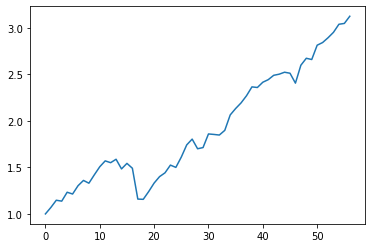

In [360]:
plt.plot(x);

In [361]:
SPY = pd.read_pickle(r'C:\Users\niels\OneDrive\Machine Learning 2022\Lecture 2\SPY_cum_ret.pkl')
SPY = SPY.loc['2004-07-01':'2018-09-30']
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0]+1)
SPY['strategy'] = x

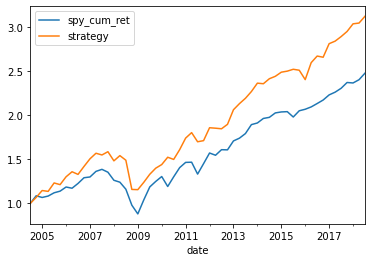

In [362]:
SPY.plot();

In [363]:
SPY = SPY.resample('Y').ffill()

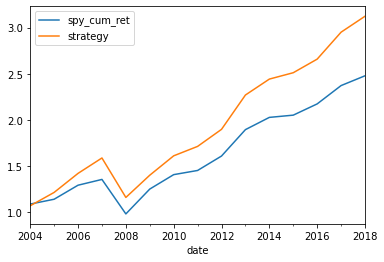

In [364]:
SPY.plot();

In [365]:
strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
strategy_std = (SPY['strategy'] - 1).diff().std()
strategy_sr = strategy_mean_ret/strategy_std
print('Strategy Sharpe Ratio: ',strategy_sr)

Strategy Sharpe Ratio:  0.8072158791958496


In [366]:
strategy_std = (SPY['strategy'] - 1).diff().std()
strategy_std

0.1817757218883073

In [367]:
(SPY['spy_cum_ret'] - 1).diff().mean()
(SPY['spy_cum_ret'] - 1).diff().std()
print('SP Sharpe Ratio: ',(SPY['spy_cum_ret'] - 1).diff().mean()/(SPY['spy_cum_ret'] - 1).diff().std())

SP Sharpe Ratio:  0.6324646748042164


In [269]:
x[-1]

3.123310489952453

In [270]:
SPY['spy_cum_ret'][-1]

2.4779340000000003

In [271]:
strategy_ret = (SPY['strategy'] - 1).diff().values[1:]
spy_ret = (SPY['spy_cum_ret'] - 1).diff().values[1:]

beta = (np.cov(spy_ret,strategy_ret)/np.var(spy_ret))[1,0]
beta

1.2156983421710987

In [104]:
residual_ret = strategy_ret - beta * spy_ret
IR = np.mean(residual_ret)/np.std(residual_ret)
IR

1.3622263859035815

In [105]:
alpha = np.mean(residual_ret)
alpha

0.05288057431135689